In [22]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [23]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [25]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [26]:
pca = PCA(n_components = 0.95)
X_reduced = pca.fit_transform(X)
X_reduced[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [27]:
from six.moves import urllib
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [28]:
from sklearn.model_selection import train_test_split

X=mnist["data"]
y=mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [29]:
pca = PCA(n_components = 0.95)
X_reduced=pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [30]:
#Randomized pca -> use stochastic algorithm to find an aproximation to the d principal components
rnd_pca =PCA(n_components = 154, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X_train)

In [31]:
#Incremental pca -> split the data into mini-batches to fit in memory
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)


X_reduced = inc_pca.transform(X_train)

In [35]:
#Non linear PCA
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples = 1000, noise =0.2, random_state = 42)

from sklearn.decomposition import KernelPCA
rbf_pca=KernelPCA(n_components = 2, kernel ="rbf", gamma = 0.04)
X_reduced = rbf_pca.fit_transform(X)

In [36]:
#Create grid search to find the best hyperparameters for the kernel
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import numpy as np

#Equivalent al model a reduir
clf = Pipeline ([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression())
])

#Parametres a modificar
param_grid = [{
    "kpca__gamma": np.linspace(0.03, 0.05, 10),
    "kpca__kernel": ["rbf", "sigmoid"]
}]
y = t > 6.9
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X,y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [37]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [38]:
#Find an inverse to kernel PCA
rbf_pca = KernelPCA(n_components = 2, kernel = "rbf", gamma = 0.0433,
                   fit_inverse_transform = True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [39]:
from sklearn.metrics import mean_squared_error
mean_squared_error(X,X_preimage)

7.81266393169597e-27

In [40]:
#Implement grid-search with cross-validation to find optimal kernel and hyperparameters that reduce
#The preimage reconstruction error

In [41]:
#LLE finds how each data instance relates to the closest neightbors, very good to unroll data
#with little noise

In [42]:
from sklearn.manifold import LocallyLinearEmbedding

lle= LocallyLinearEmbedding(n_components =2, n_neighbors = 10)
X_reduced = lle.fit_transform(X)

Saving figure lle_unrolling_plot


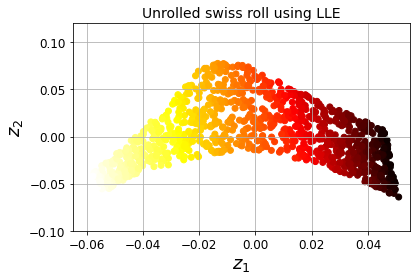

In [44]:
import matplotlib.pyplot as plt
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.show()